In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [218]:
# Chargement des données de débit
file_path_debit = r'Y:\MISSIONS\Eau\8 - Projet recherche Célé\Gaetan\Courbe de tarage\Bullac\Hydrogramme1.csv'
data_debit = pd.read_csv(file_path_debit, sep=';')

# Chargement des données d'ERA5
file_path_era5 = r'C:\Users\stagiaire\Desktop\DATA\ERA5\ERA5_07_2024_Bullac.csv'
data_era5 = pd.read_csv(file_path_era5, sep=';', parse_dates=['Date'], dayfirst=True)

# Convertir les colonnes 'Year', 'Month', 'Day', 'Hour' en une seule colonne 'Date'
data_debit['Date'] = pd.to_datetime(data_debit[['Year', 'Month', 'Day', 'Hour']])
data_debit = data_debit.drop(columns=['Sec'])  

# Convertir les colonnes de débit en types numériques
for col in ['Qmaxpost[m3/s]', 'Qlow_stage+param[m3/s]', 'Qhigh_stage+param[m3/s]']:
    data_debit[col] = pd.to_numeric(data_debit[col], errors='coerce')

data_debit_daily = data_debit.resample('D', on='Date').mean().reset_index()

data_era5['Date'] = pd.to_datetime(data_era5['Date'])
data_era5.sort_values('Date', inplace=True)
data_debit_daily.sort_values('Date', inplace=True)

# Fusionner les deux DataFrames sur la colonne 'Date'
data = pd.merge(data_debit_daily, data_era5, on='Date', how='left')

print(data.head(3))


        Date    Year  Month   Day  Hour  Min  Qmaxpost[m3/s]  \
0 2024-01-24  2024.0    1.0  24.0  19.0  0.0        0.065371   
1 2024-01-25  2024.0    1.0  25.0  11.5  0.0        0.061386   
2 2024-01-26  2024.0    1.0  26.0  11.5  0.0        0.054893   

   Qlow_stage[m3/s]  Qhigh_stage[m3/s]  Qlow_stage+param[m3/s]  \
0          0.061010           0.069845                0.050637   
1          0.057217           0.065874                0.048004   
2          0.050754           0.059082                0.043065   

   Qhigh_stage+param[m3/s]  Qlow_total[m3/s]  Qhigh_total[m3/s]  Pluie (mm)  \
0                 0.252768         -0.038240           0.350075    0.435141   
1                 0.236697         -0.027414           0.333610    0.442286   
2                 0.210300         -0.028197           0.283525    0.012057   

   ETR (mm)  ETP (mm)  Temp (°C)  
0  0.350505 -0.657542   8.116107  
1  0.291447 -0.463388   7.099928  
2  0.595270 -1.418591   7.017222  


In [219]:
import pandas as pd
import numpy as np

# Paramètres constants
RUmax = 41.45 # Valeur maximale des réserves utilitaires

# Initialisation des colonnes de résultats
data['RU'] = 0.0
data['PeffGR'] = 0.0
data['InWater'] = 0.0  # Cette colonne sera calculée

# Initialiser la première valeur de RU avec RUinit
data.at[0, 'RU'] = RUmax

# Fonction pour calculer RU et PeffGR
def calcul_pluie_efficace(data, RUmax, RFU):
    for i in range(1, len(data)):
        Pluie = data.loc[i, 'Pluie (mm)']
        ETP = data.loc[i, 'ETR (mm)']
        RU_prev = data.loc[i - 1, 'RU']
        
        # Calcul de la quantité d'eau entrant (pluie)
        InWater = Pluie
        data.loc[i, 'InWater'] = InWater

        if InWater >= ETP:
            Pn = InWater - ETP 
            RU = (RU_prev + RUmax * np.tanh(Pn / RUmax)) / (1 + (RU_prev / RUmax) * np.tanh(Pn / RUmax))
            PeffGR = RU_prev - RU + Pn
        else:
            Pn = 0
            En = ETP - InWater
            RU = RU_prev * (1 - np.tanh(En / RUmax)) / (1 + (1 - RU_prev / RFU) * np.tanh(En / RUmax))
            PeffGR = 0

        data.loc[i, 'RU'] = RU
        data.loc[i, 'PeffGR'] = PeffGR

    return data

# Appeler la fonction pour calculer les valeurs
data = calcul_pluie_efficace(data, RUmax, RFU)

# Sélectionner les colonnes d'intérêt
columns_of_interest = ['Date', 'PeffGR','RU', 'InWater', 'Qmaxpost[m3/s]', 'Qlow_stage+param[m3/s]', 'Qhigh_stage+param[m3/s]']
output_data = data[columns_of_interest]

# Sauvegarder les données dans un nouveau fichier CSV
output_file_path = 'C:/Users/stagiaire/Desktop/Bilan_Bullac.csv'
output_data.to_csv(output_file_path, index=False)

print("Les données ont été mises à jour et sauvegardées dans le fichier :", output_file_path)


Les données ont été mises à jour et sauvegardées dans le fichier : C:/Users/stagiaire/Desktop/Bilan_Bullac.csv


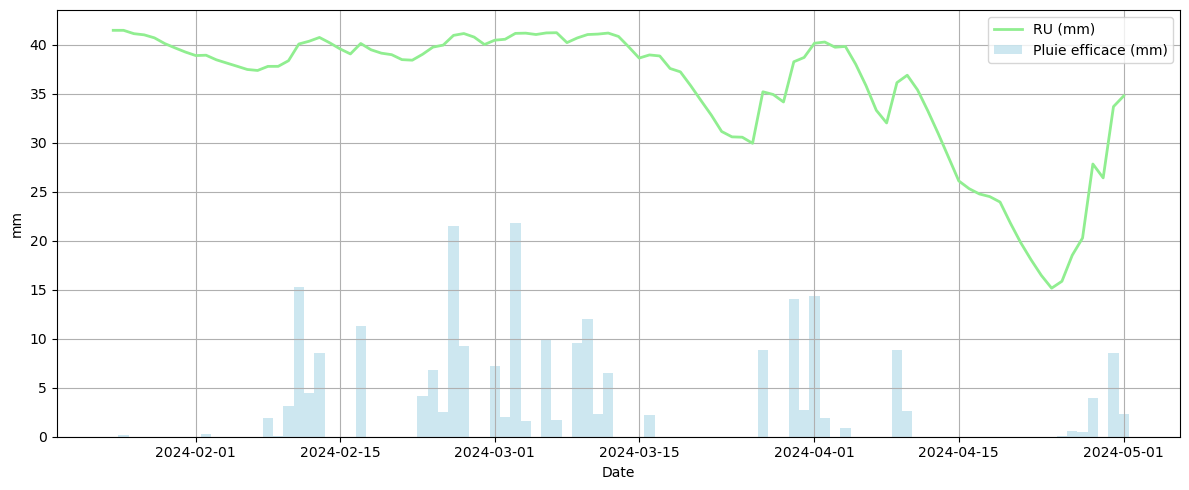

In [220]:
import pandas as pd
import matplotlib.pyplot as plt

# Chemin du fichier CSV
file_path = 'C:/Users/stagiaire/Desktop/Bilan_Pito.csv'

# Charger les données depuis le fichier CSV
data = pd.read_csv(file_path, sep=';', parse_dates=['Date'], dayfirst=True)

# Vérifier et nettoyer la colonne 'Date'
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Convertir les dates, valeurs incorrectes deviennent NaT
data = data.dropna(subset=['Date'])  # Supprimer les lignes où 'Date' est NaT

# Vérifier les colonnes nécessaires
required_columns = ['Date', 'PeffGR', 'RU']
for col in required_columns:
    if col not in data.columns:
        raise ValueError(f"La colonne '{col}' est manquante dans le fichier CSV.")

# Vérifier si 'PeffGR' et 'RU' contiennent des valeurs numériques
data['PeffGR'] = pd.to_numeric(data['PeffGR'], errors='coerce')
data['RU'] = pd.to_numeric(data['RU'], errors='coerce')

# Supprimer les lignes avec des valeurs manquantes dans 'PeffGR' et 'RU'
data = data.dropna(subset=['PeffGR', 'RU'])

# Création du graphique avec histogramme pour la pluie efficace et courbe pour la RU
plt.figure(figsize=(12, 5))

# Création de l'histogramme pour la pluie efficace
plt.bar(data['Date'], data['PeffGR'], color='lightblue', width=1, alpha=0.6, label='Pluie efficace (mm)')

# Création de la courbe pour RU
plt.plot(data['Date'], data['RU'], color='lightgreen', linestyle='-', linewidth=2, label='RU (mm)')

# Ajout des labels et titre
plt.xlabel('Date')
plt.ylabel('mm')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()  # Ajuster les espacements pour le sous-graphe

# Afficher le graphique
plt.show()



In [221]:
# Chargement des données depuis le fichier CSV
file_path = 'C:/Users/stagiaire/Desktop/Bilan_Bullac.csv'
data = pd.read_csv(file_path,sep=';')

# Calcul de la somme des colonnes pertinentes en m³/jour
sum_pluie_efficace_mm = data['PeffGR'].sum()
sum_qmax_m3h = (data['Qmaxpost[m3/s]'] * 86400).sum()
sum_qlow_m3h = (data['Qlow_stage+param[m3/s]'] * 86400).sum()
sum_qhigh_m3h = (data['Qhigh_stage+param[m3/s]'] * 86400).sum()

# Calcul de la surface en km² pour les valeurs min, moyenne et max
surface_min = sum_qlow_m3h / sum_pluie_efficace_mm / 1000
surface = sum_qmax_m3h / sum_pluie_efficace_mm / 1000
surface_max = sum_qhigh_m3h / sum_pluie_efficace_mm / 1000

print(f"Surface minimale estimée: {surface_min:.2f} km²")
print(f"Surface moyenne estimée: {surface:.2f} km²")
print(f"Surface maximale estimée: {surface_max:.2f} km²")


Surface minimale estimée: 17.40 km²
Surface moyenne estimée: 22.37 km²
Surface maximale estimée: 52.37 km²
